In [1]:
import os
import numpy as np
import cv2
from tqdm import tqdm
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import itertools
import random
from sklearn.utils import shuffle
from keras import layers
from keras import models
from keras import backend as K

In [2]:
os.chdir('/content/drive/MyDrive/Signature/signature_data_one_shot')

In [3]:
!ls

model_plot.png		       test_data   validation_data
signature_forgery_one_shot.h5  train_data


In [4]:
def get_data(dir):
    orig = []
    forg = []
    for name in tqdm(sorted(os.listdir(dir))):
        original = []
        forged = []
        for image_name in sorted(os.listdir(dir+'/'+name)):
            img = dir+'/'+name+'/'+image_name
            if 'forg' in name.lower():
                forged.append(img)
            else:
                original.append(img)
        
        if 'forg' in name.lower():
            forg.append(forged)
        else:
            orig.append(original)
    
    return orig, forg
     

In [5]:
train_orig, train_forg = get_data('train_data')
validation_orig, validation_forg = get_data('validation_data')
test_orig, test_forg = get_data('test_data')

100%|██████████| 14/14 [00:01<00:00, 10.94it/s]


In [6]:
print(len(train_orig))
print(len(train_forg))
print(len(validation_orig))
print(len(validation_forg))
print(len(test_orig))
print(len(test_forg))

50
50
7
7
7
7


In [7]:
img = cv2.imread(train_orig[0][4], cv2.IMREAD_GRAYSCALE)

In [8]:
img.shape

(268, 650)

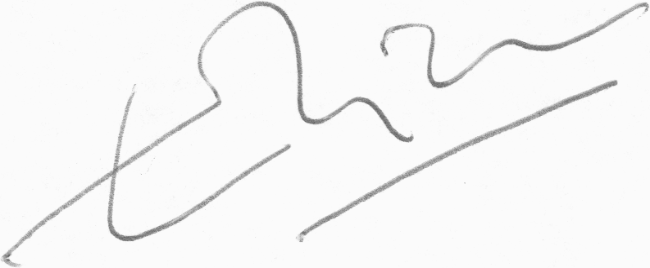

In [9]:
cv2_imshow(img)

In [10]:
def generate_batch(orig_groups, forg_groups, batch_size = 32):
    '''Function to generate a batch of data with batch_size number of data points
    Half of the data points will be Genuine-Genuine pairs and half will be Genuine-Forged pairs'''
    while True:
        orig_pairs = []
        forg_pairs = []
        gen_gen_labels = []
        gen_for_labels = []
        all_pairs = []
        all_labels = []
        
        # Here we create pairs of Genuine-Genuine image names and Genuine-Forged image names
        # For every person we have 12 genuine signatures, hence we have 
        # 12 choose 2 = 66 Genuine-Genuine image pairs for one person.
        # To make Genuine-Forged pairs, we pair every Genuine signature of a person
        # with 8 Forged signatures of the same person.
        # Thus we make 12 * 8 = 96 Genuine-Forged image pairs for one person.
        # In all we have 50 person's data in the training data.
        # Total no. of Genuine-Genuine pairs = 50 * 66 = 3300
        # Total number of Genuine-Forged pairs = 50 * 96 = 4800
        # Total no. of data points = 3300 + 4800 = 8100
        for orig, forg in zip(orig_groups, forg_groups):
            orig_pairs.extend(list(itertools.combinations(orig, 2)))
            for i in range(len(orig)):
                forg_pairs.extend(list(itertools.product(orig[i:i+1], forg)))
        
        # Label for Genuine-Genuine pairs is 1
        # Label for Genuine-Forged pairs is 0
        gen_gen_labels = [1]*len(orig_pairs)
        gen_for_labels = [0]*len(forg_pairs)
        
        # Concatenate all the pairs together along with their labels and shuffle them
        all_pairs = orig_pairs + forg_pairs
        all_labels = gen_gen_labels + gen_for_labels
        del orig_pairs, forg_pairs, gen_gen_labels, gen_for_labels
        all_pairs, all_labels = shuffle(all_pairs, all_labels)
            
        k = 0
        pairs=[np.zeros((batch_size, 268, 650, 1)) for i in range(2)]
        targets=np.zeros((batch_size,))
        for ix, pair in enumerate(all_pairs):
            img1 = cv2.imread(pair[0], cv2.IMREAD_GRAYSCALE)
            img2 = cv2.imread(pair[1], cv2.IMREAD_GRAYSCALE)
            img1 = np.array(img1, dtype = np.float64)
            img2 = np.array(img2, dtype = np.float64)
            img1 /= 255
            img2 /= 255
            img1 = img1[..., np.newaxis]
            img2 = img2[..., np.newaxis]
            pairs[0][k, :, :, :] = img1
            pairs[1][k, :, :, :] = img2
            targets[k] = all_labels[ix]
            k += 1
            if k == batch_size:
                yield pairs, targets
                k = 0
                pairs=[np.zeros((batch_size, 268, 650, 1)) for i in range(2)]
                targets=np.zeros((batch_size,))

In [11]:
def euclidean_distance(vects):
    '''Compute Euclidean Distance between two vectors'''
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))
     

In [12]:
def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [13]:
import sys
import numpy as np
import pandas as pd
import pickle
import os
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import time
import itertools
import random

from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
# from keras.optimizers import Adam, RMSprop
from tensorflow.keras.optimizers import Adam
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate, Dropout
from keras.models import Model
from keras.layers import (BatchNormalization, SeparableConv2D, MaxPooling2D,GlobalAveragePooling2D,
                                     Activation, Flatten, Dropout, Dense, Lambda)

from keras.initializers import glorot_uniform
from keras.utils.layer_utils import get_source_inputs
#from keras.engine.topology import Layer
from keras.regularizers import l2
from keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [14]:
def create_base_network_signet(input_shape):
    '''Base Siamese Network'''
    
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape,padding='same'))
    model.add(layers.MaxPooling2D((2, 2),padding='same'))
    model.add(layers.Conv2D(64, (3, 3), activation='relu',padding='same'))
    model.add(layers.MaxPooling2D((2, 2),padding='same'))
    model.add(layers.Conv2D(64, (3, 3), activation='relu',padding='same'))
    model.add(layers.MaxPooling2D((2, 2),padding='same'))
    model.add(layers.Flatten())
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.Dense(128, activation='relu'))

    return model

In [15]:
input_shape=(268, 650, 1)

In [16]:
base_network = create_base_network_signet(input_shape)

input_a = Input(shape=(input_shape))
input_b = Input(shape=(input_shape))

processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = layers.Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])
prediction = layers.Dense(1,activation='sigmoid')(distance)

model = models.Model(inputs=[input_a, input_b], outputs=prediction)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 268, 650, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 268, 650, 1  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 128)          182902336   ['input_1[0][0]',                
                                                                  'input_2[0][0]']            

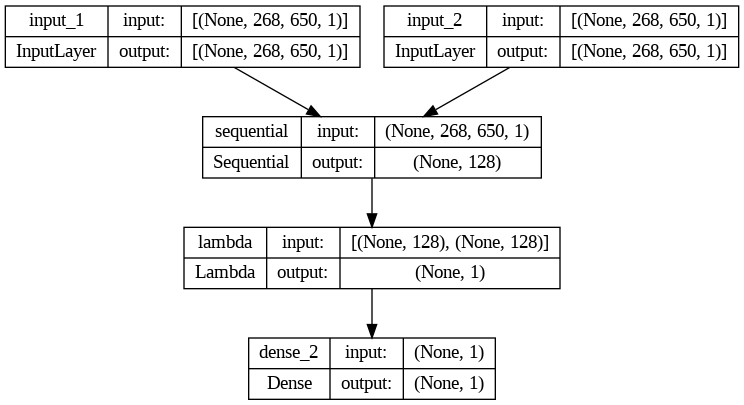

In [17]:
from keras.models import Sequential
from keras.utils.vis_utils import plot_model
plot_model(model, to_file = 'model_plot.png', show_shapes=True, show_layer_names=True)

In [18]:
model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['accuracy'])

In [19]:
num_train_samples = 66*50 + 96*50
num_val_samples = num_test_samples = 66*7 + 96*7
num_train_samples, num_val_samples, num_test_samples

(8100, 1134, 1134)

In [20]:
batch_size=64
history = model.fit(generate_batch(train_orig, train_forg, batch_size),
                   steps_per_epoch = num_train_samples//batch_size,
                   epochs = 4,
                   validation_data = generate_batch(validation_orig, validation_forg, batch_size),
                   validation_steps = num_val_samples//batch_size)

Epoch 1/4
126/126 [==============================] - 374s 3s/step - loss: 0.3363 - accuracy: 0.7987 - val_loss: 0.2809 - val_accuracy: 1.0000
Epoch 2/4
126/126 [==============================] - 106s 847ms/step - loss: 0.2591 - accuracy: 0.9896 - val_loss: 0.2454 - val_accuracy: 1.0000
Epoch 3/4
126/126 [==============================] - 106s 846ms/step - loss: 0.2311 - accuracy: 0.9932 - val_loss: 0.2238 - val_accuracy: 1.0000
Epoch 4/4
126/126 [==============================] - 114s 904ms/step - loss: 0.2080 - accuracy: 0.9952 - val_loss: 0.2039 - val_accuracy: 1.0000


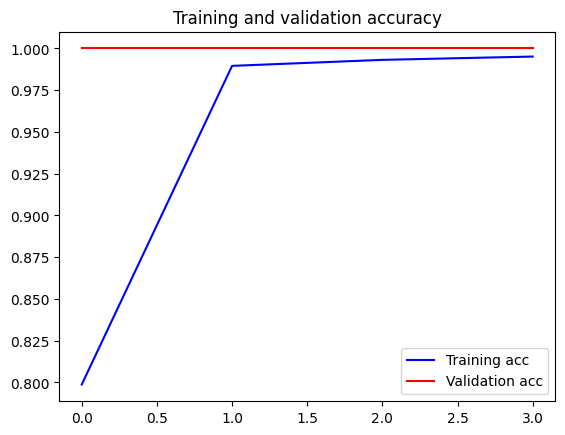

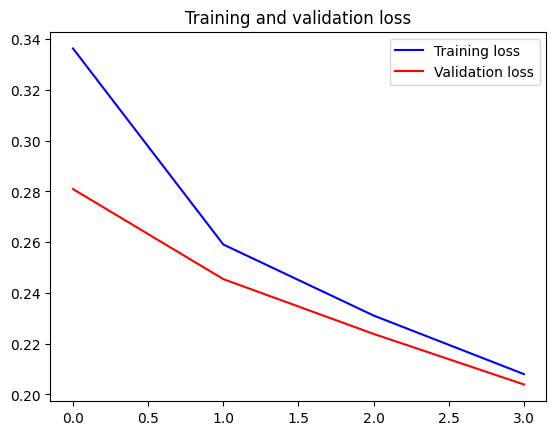

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [22]:
test_loss, test_acc = model.evaluate(generate_batch(test_orig, test_forg, 1), steps=num_test_samples)
test_acc

1134/1134 [==============================] - 53s 46ms/step - loss: 0.1995 - accuracy: 1.0000


1.0

In [23]:
model.save('signature_forgery_one_shot.h5')

In [24]:
model.save('signature_forgery_one_shot.hdf5')

In [25]:
model = models.load_model('signature_forgery_one_shot.h5')

In [44]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [26]:

def show_images(path_img_1, path_img_2):
    img1 = cv2.imread(path_img_1, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(path_img_2, cv2.IMREAD_GRAYSCALE)

    cv2_imshow(img1)
    cv2_imshow(img2)

In [27]:
def check_forgery(path_img_1, path_img_2):
    img1 = cv2.imread(path_img_1, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(path_img_2, cv2.IMREAD_GRAYSCALE)
    width = 650
    height = 268
    dim = (width, height)

    # resize image
    img1 = cv2.resize(img1, dim, interpolation = cv2.INTER_AREA)
    img2 = cv2.resize(img2, dim, interpolation = cv2.INTER_AREA)
    cv2_imshow(img1)
    cv2_imshow(img2)
    img1 = img1.reshape((1, 268, 650, 1))
    img2 = img2.reshape((1, 268, 650, 1))
    img1 = img1.astype('float32') / 255
    img2 = img2.astype('float32') / 255


    if model.predict((img1, img2))[0][0] >=0.5:
        return 'Genuine Signatures'
    else:
        return 'Forged Signatures'
     

In [28]:

!ls test_data


063	  064	    065       066	067	  068	    069
063_forg  064_forg  065_forg  066_forg	067_forg  068_forg  069_forg


In [29]:
!ls test_data/063

01_063.png  03_063.png	05_063.png  07_063.png	09_063.png  11_063.png
02_063.png  04_063.png	06_063.png  08_063.png	10_063.png  12_063.png


In [30]:
!ls test_data/063_forg
     

01_0104063.PNG	01_0119063.PNG	02_0108063.PNG	03_0104063.PNG
01_0108063.PNG	02_0104063.PNG	02_0119063.PNG	03_0108063.PNG


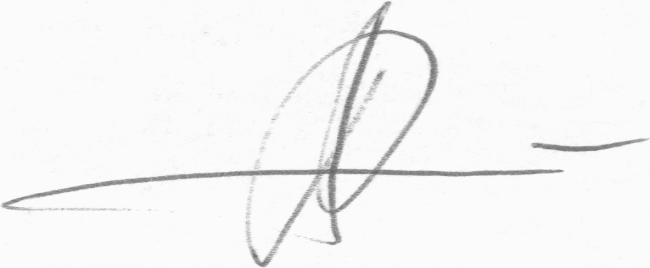

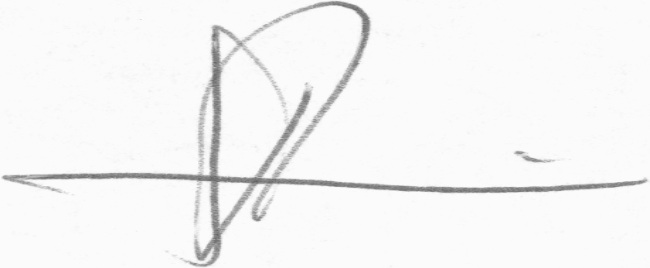

In [31]:
# visualizing the two images
show_images('test_data/063/01_063.png', 'test_data/063/02_063.png')

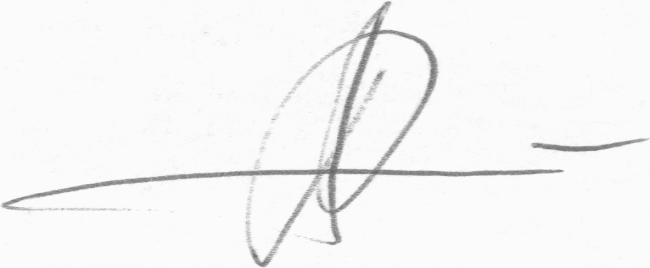

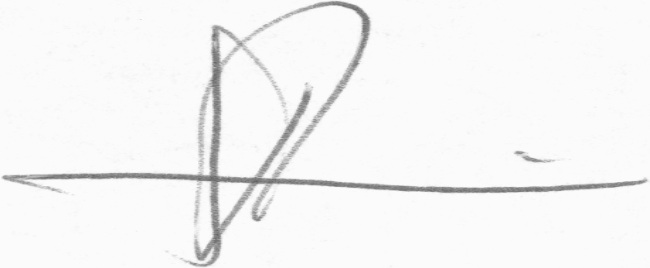

1/1 [==============================] - 0s 203ms/step


'Genuine Signatures'

In [32]:
# Checking Forgery
check_forgery('test_data/063/01_063.png', 'test_data/063/02_063.png')

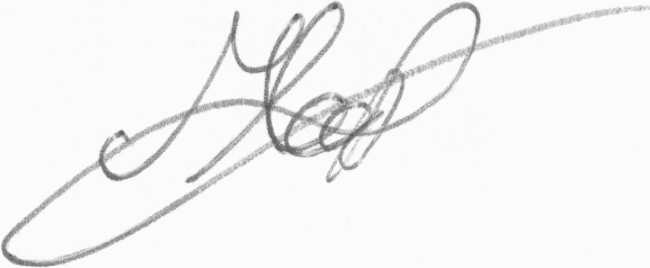

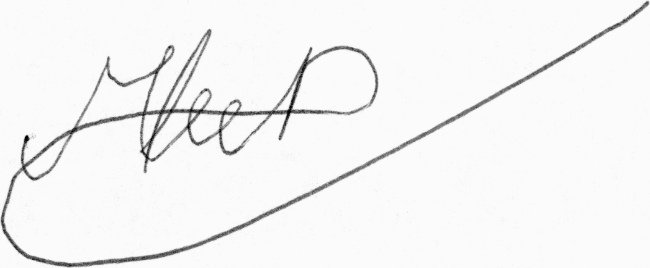

1/1 [==============================] - 0s 20ms/step


'Forged Signatures'

In [34]:
check_forgery('test_data/064/05_064.png', 'test_data/064_forg/01_0203064.PNG')

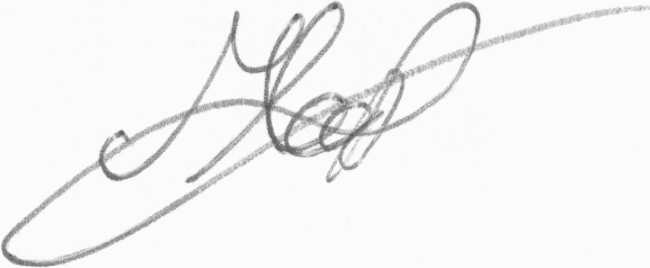

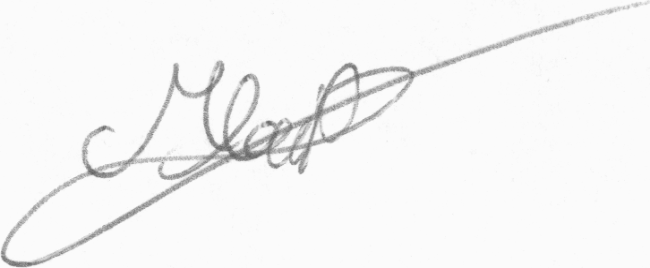

1/1 [==============================] - 0s 21ms/step


'Genuine Signatures'

In [35]:
check_forgery('test_data/064/05_064.png', 'test_data/064/01_064.png')

In [36]:
# Model saving
model.save("signature_model")

In [39]:
# Model evaluation
eval_test=model.evaluate(generate_batch(test_orig, test_forg, 1), steps=num_test_samples)
eval_train=model.evaluate(generate_batch(train_orig, train_forg, 1), steps=num_train_samples)
print(f'Nilai Accuracy Xception Testing (setelah Improvement) = {round((eval_test[1]),3)} ')
print(f'Nilai Accuracy Xception Training (setelah Improvement) = {round((eval_train[1]),3)} ')

8100/8100 [==============================] - 111s 14ms/step - loss: 0.1964 - accuracy: 0.9954
Nilai Accuracy Xception Testing (setelah Improvement) = 1.0 
Nilai Accuracy Xception Training (setelah Improvement) = 0.995 
